In [3]:
import pandas as pd
import numpy as np
from time import time
import json
from sqlalchemy import create_engine
import re
import datetime
from mpl_toolkits.basemap import Basemap

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('seaborn-whitegrid')
import numpy as np
from mpl_toolkits.basemap import Basemap
from geopy.distance import distance as dist

In [4]:
# Set up the SQL connection
dbname = 'redshift'
url = 'panamera-ods.cnsuxis6zqxr.us-west-2.redshift.amazonaws.com:5439/panameraods'
engine = create_engine("postgresql://" + 'lucasdresl' + ":" + 'cQsY801a76x82x62aWDT' + "@" + url)


###  Location tabla de evento

In [5]:
query = """

drop table if exists sold_items;
select
  id,
  region_id,
  district_id,
  city_id,
  category_id,
  user_id,
  buyer_id
   into temp table sold_items
  from livesync.panamera_ads
where status='sold'
  and livesync_dbname = 'olxin'
  and created_at > '2019-07-15'
  and buyer_id != 0
  and source='android'
  
;drop table if exists ids;
select
 distinct buyer_id as user_nk into temp ids from sold_items
union all
select distinct user_id as user_nk  from  sold_items

;drop table if exists lat_and_long_mode;
select
 
       a.user_nk,
       lat::float,
       long::float,
       count(*) as events
    into temp table lat_and_long_mode
  from ods.panameraolx_asia_hydra_ninja_android_last_month a
    join ids b on a.user_nk=b.user_nk
     where
           user_sk != 'unknown'
       and lat != ''
       and long != ''
       and lat is not null
       and long is not null
       and long!='NaN'
group by 1,2,3;

;drop table if exists lat_long_table;
select
  a.*,
  b.lat as lat_buyer,
  b.long as long_buyer,
  c.map_lat as lat_item,
  c.map_lon as long_item,
  b.events as event_buyer
   into temp table lat_long_table
  from sold_items a
    join lat_and_long_mode b on a.buyer_id=b.user_nk
    join (select ad_id,map_lat,map_lon from livesync.panamera_locations where livesync_dbname='olxin' group by 1,2,3) c on a.id=c.ad_id;

select
  a.*,
  b.category_l1_name_en,
  b.category_l2_name_en
   from lat_long_table a
    left join (select category_nk , category_l1_name_en , category_l2_name_en from ods.dim_categories where country_sk='olx|asia|in') b on a.category_id=b.category_nk

"""

In [6]:
df = pd.read_sql_query(query.replace('%', '%%'), engine)


In [7]:
df.head()


,id,region_id,district_id,city_id,category_id,user_id,buyer_id,lat_buyer,long_buyer,lat_item,long_item,event_buyer,category_l1_name_en,category_l2_name_en
0,1049783047,2001160,5419165.0,4396321,1523,104124911,154996581,8.505135,77.082825,9.635463,76.564537,54,Electronics & Appliances,"TVs, Video - Audio"
1,1145132897,2001159,5313945.0,4058803,1793,156223421,408870576,12.966260,77.553177,12.820973,77.661131,3114,Fashion,Men
2,1162713695,2001159,5457962.0,4058803,1505,143293385,259415661,12.966260,77.553177,12.966800,77.635100,965,Electronics & Appliances,Computers & Laptops
3,1175595533,2001155,5309677.0,4058748,771,192501061,224724009,28.667700,77.081802,28.509821,77.055054,472,"Books, Sports & Hobbies",Gym & Fitness
4,1175595533,2001155,5309677.0,4058748,771,192501061,224724009,28.567080,77.240311,28.509821,77.055054,392,"Books, Sports & Hobbies",Gym & Fitness


In [8]:
df['distance_user'] = df.apply(lambda x: dist((x['lat_buyer'], x['long_buyer']), 
                                              (x['lat_item'], x['long_item'])).km ,axis=1)


### Graph visualization example

/Users/lucas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if sys.path[0] == '':
/Users/lucas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/Users/lucas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


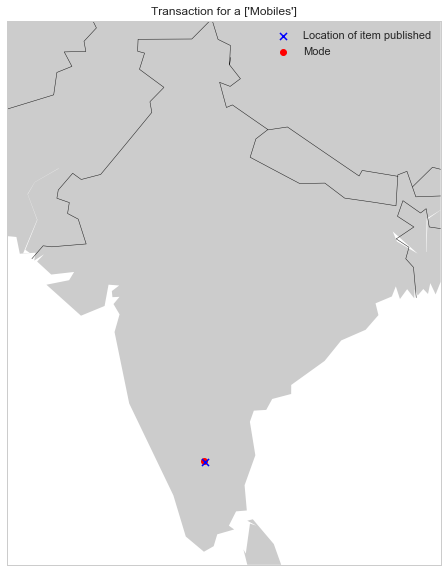

Distance between location of item published and mode buyer location:[5.55144571]km
Events seen with this location:[3564]


In [9]:
df_uno = df['id'].sample(n=1)
A = df['id'].unique()
id_random = A[np.random.choice(A.shape[0], replace=False)]
df_random = df[df['id'] == id_random]

plt.figure(figsize=(20,10))
m = Basemap(projection='mill' ,
           llcrnrlat = 7.363669,
           llcrnrlon = 66.791601,
           urcrnrlat = 35.518939,
           urcrnrlon = 90.470235,
           resolution='c')

#m = Basemap(projection='mill' ,
#           llcrnrlat = df_random['lat_buyer'].min() - 0.2 ,
#           llcrnrlon = df_random['long_buyer'].min() - 0.2 ,
#           urcrnrlat = df_random['lat_item'].unique() + 0.2 ,
#           urcrnrlon = df_random['long_item'].unique() + 0.2 
#           )


m.drawcountries()
m.fillcontinents()
m.drawstates(color='b')


item_lat , item_long  = df_random['lat_item'].unique(), df_random['long_item'].unique() 
xpt , ypt = m(item_long , item_lat)
#m.plot(xpt , ypt , 'c*' , markersize=20 , label='Location of item' , color='blue')
m.scatter(xpt , ypt,zorder=6, c='blue' ,marker='x' , edgecolors='none' , s=50 , label='Location of item published' )

#lat_b , lon_b , size_b = df_random['lat_buyer'].unique(), df_random['long_buyer'].unique() , df_random['event_buyer']*1/100
#xpt , ypt = m(lon_b , lat_b)
#m.plot(xpt , ypt , 'c*' , markersize=5 , label='Buyer movements' , color='red')
#m.scatter(xpt , ypt,zorder=3,s=size_b, c='red',marker='o' , label='Buyer movements')

lat_b , lon_b , size_b =  df_random[df_random['event_buyer'] == df_random['event_buyer'].max()].lat_buyer.unique(), df_random[df_random['event_buyer'] == df_random['event_buyer'].max()].long_buyer.unique(), df_random[df_random['event_buyer'] == df_random['event_buyer'].max()].event_buyer * 1/100
xpt , ypt = m(lon_b , lat_b)
#m.plot(xpt , ypt , 'c*' , markersize=5 , label='Buyer movements' , color='red')
m.scatter(xpt , ypt,zorder=3,s=size_b, c='red',marker='o' , label='Mode')


plt.legend()
plt.title('Transaction for a {}'.format(df_random['category_l1_name_en'].unique()))
plt.show()
print('Distance between location of item published and mode buyer location:' + str(df_random[df_random['event_buyer'] == df_random['event_buyer'].max()].distance_user.unique()) + 'km')
print('Events seen with this location:' + str(df_random[df_random['event_buyer'] == df_random['event_buyer'].max()].event_buyer.unique()))

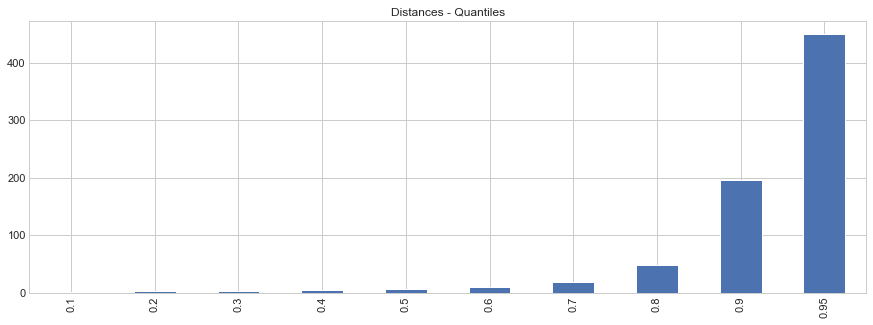

In [10]:
df['max_event'] = df.groupby(['id'])['event_buyer'].transform('max')
df['max_value'] = np.where(df['max_event'] == df['event_buyer'] , 1,0)
dfmode = df[df['max_value'] ==1]
dfmode.distance_user.quantile([.1,.2,.3,.4,.5,.6,.7,.8,.9, .95]).plot(kind='bar' , figsize=(15,5) , title='Distances - Quantiles')

In [11]:
dfmode.distance_user.quantile([.1,.2,.3,.4,.5,.6,.7,.8,.9, .95])


0.10      1.403610
0.20      2.424843
0.30      3.447408
0.40      4.520115
0.50      6.173798
0.60      9.936380
0.70     18.953548
0.80     47.590466
0.90    196.321637
0.95    450.070703
Name: distance_user, dtype: float64

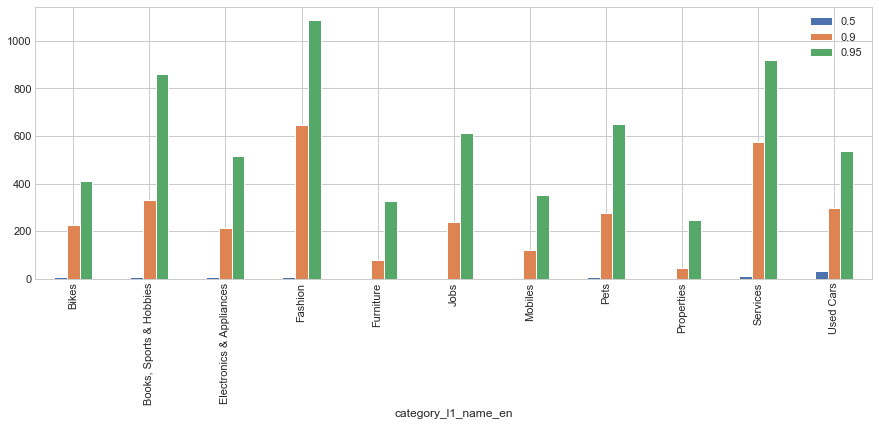

In [13]:
dfmode.groupby(['category_l1_name_en']).distance_user.quantile([.5, .9, .95]).unstack().plot(kind='bar' , figsize=(15,5))

### Find aristas